In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorboardX

from tensorboardX import SummaryWriter
from datetime import datetime
from torchvision import datasets
from collections import defaultdict, deque
import torchvision.transforms.functional as TF
import torchvision.transforms as TT
import itertools
import torchvision.models as models
import torch, os, random, zipfile, re, pickle, logging
from copy import deepcopy
from collections import OrderedDict
import numpy as np, torch.nn as nn, pandas as pd,\
torch.nn.functional as F, matplotlib.pyplot as plt,\
seaborn as sn
from time import time, sleep
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR, LambdaLR
from string import punctuation
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    Subset, 
    RandomSampler, 
    SequentialSampler, 
    Dataset
)
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, 
    roc_auc_score, 
    precision_recall_fscore_support
)

In [ ]:
def download_dirs(dirlist):
    from google.colab import files
    for dirname in dirlist:
        for filename in os.listdir(dirname):
            filename = os.path.join(dirname, filename)
            files.download(filename)

def get_dataLoader(dataset, valid_portion, batch_sizes, shuffle_indices, pretrain=False, pre_seed=None, **kwargs):
    n_samples = len(dataset)
    valid_size = int(len(dataset)*valid_portion)
    train_size = len(dataset)-valid_size
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    if pretrain and pre_seed:
        new_seed = np.random.randint(pre_seed+100, 2*pre_seed+101)
        fix_seed(new_seed, random_lib=True, numpy_lib=True, torch_lib=True)
    train_loader = DataLoader(
        train_dataset, shuffle=True, batch_size=batch_sizes[0], **kwargs
    )
    valid_loader = DataLoader(
        valid_dataset, shuffle=False, batch_size=batch_sizes[1], **kwargs
    )
    return train_loader, valid_loader

def fix_seed(seed_value, random_lib=False, numpy_lib=False, torch_lib=False):
    if random_lib:
        random.seed(seed_value)
    if numpy_lib:
        np.random.seed(seed_value)
    if torch_lib:
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)

def setup_logger(name, format=None, level=logging.DEBUG, handlers=None, log_file='default.log'):
    logging.basicConfig(
        level=level, 
        format=format if format else '%(asctime)s [%(levelname)s] %(message)s',
        handlers=handlers if handlers else [
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(name)
    logger.setLevel(level)

def make_configure():
    import argparse
    parser = argparse.ArgumentParser(description='Model Configuration')
    parser.add_argument('--lr', type=float, default=.001, help='learning rate')
    parser.add_argument('--n_epochs', type=int, help='number of epochs')
    args = parser.parse_args()
    return args

In [ ]:
class CifarCPCRotate(datasets.CIFAR10):
    def __init__(self, path, n_priors, n_posteriors, rotate_range=(0, 360), preprocess=[], train=True):
        super().__init__(path, train, download=True)
        self.prior_rotates = np.linspace(*rotate_range, n_priors, dtype=np.int16)
        self.set_transforms(preprocess)
        self.targets = np.array(self.targets)
        self.n_posteriors = n_posteriors

    def set_transforms(self, preprocess: list=[]):
        if not preprocess:
            self.preprocess = self.default_preprocess()
        else:
            self.preprocess = preprocess
        self.custom_transforms = TT.Compose([
            *self.preprocess
        ])

    def default_preprocess(self):
        preprocess = [
            TT.ToTensor(),
            TT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
        return preprocess

    def __len__(self):
        return super().__len__()

    def __getitem__(self, index):
        true_imgs = []
        img, img_label = super().__getitem__(index)
        for angle in self.prior_rotates:
            temp_img = self.custom_transforms(TF.rotate(img, int(angle))).unsqueeze(0)
            true_imgs.append(temp_img)
        true_imgs = torch.cat(true_imgs)
        other_idxs = np.arange(0, self.__len__())
        rand_idxs = np.random.choice(other_idxs[(other_idxs!=index) & (self.targets!=img_label)], self.n_posteriors-1)
        true_idx = np.random.choice(range(self.n_posteriors))
        false_imgs = []
        for idx in rand_idxs:
            fimg, _ = super().__getitem__(idx)
            # p = random.random()
            # if p > 0.7:
            #     r = random.choice(range(180))
            #     fimg = TF.rotate(img, r)
            fimg = self.custom_transforms(fimg).unsqueeze(0)
            false_imgs.append(fimg)
        false_imgs.insert(true_idx, self.custom_transforms(img).unsqueeze(0))
        false_imgs = torch.cat(false_imgs)
        return true_imgs, false_imgs, true_idx

class CPCEncoder(nn.Module):
    def __init__(self, encoder_type, out_dim=128, pretrained=False):
        super(CPCEncoder, self).__init__()
        self.set_encoder(encoder_type, out_dim, pretrained)
    
    def set_encoder(self, encoder_type, out_dim, pretrained):
        if encoder_type == 'resnet':
            self.encoder = models.resnet18(pretrained=pretrained, progress=True)
            self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            self.encoder.maxpool = nn.Identity()
            self.encoder.fc = nn.Linear(in_features=512, out_features=out_dim, bias=True)
        elif encoder_type == 'vgg':
            self.encoder = models.vgg16_bn(pretrained=pretrained, progress=True).features
            channel_mapping = {64:16, 128:32, 256:64, 512:128}
            for i, layer in enumerate(self.encoder):
                conv_change = False
                if isinstance(layer, nn.Conv2d):
                    in_channels = layer.in_channels
                    out_channels = layer.out_channels
                    if in_channels in channel_mapping:
                        in_channels = channel_mapping[in_channels]
                        conv_change = True
                    if out_channels in channel_mapping:
                        out_channels = channel_mapping[out_channels]
                        conv_change = True
                elif isinstance(layer, nn.BatchNorm2d):
                    self.encoder[i] = nn.BatchNorm2d(
                        channel_mapping[layer.num_features], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                    )
                if conv_change:
                    self.encoder[i] = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.encoder.add_module('avgpool', nn.AdaptiveAvgPool2d(output_size=(5, 5)))
            self.encoder.add_module('flatten', nn.Flatten(start_dim=1))
            self.encoder.add_module('fc', nn.Linear(in_features=128*5*5, out_features=out_dim, bias=True))

    def forward(self, inputs):
        inputs_size = inputs.size() # (batch_size, input_len, channels, width, height) if batch_first else (input_len, batch_size, channels, width, height)
        inputs = inputs.view(-1, *inputs_size[2:]) # (batch_size*input_len, channels, width, height)
        output = self.encoder(inputs)
        output = output.view(inputs_size[0], inputs_size[1], -1) # (batch_size, input_len, out_dim) if batch_first else (input_len, batch_size, out_dim)
        return output
    
class CPCAutoregressive(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=256, n_layers=2, bidirectional=False):
        super(CPCAutoregressive, self).__init__()
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            n_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        self.n_layers = n_layers
        self.bid_value = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        
    def forward(self, inputs):
        h0 = torch.zeros((self.n_layers*self.bid_value,
                          inputs.size(0),
                          self.hidden_dim)).to(inputs.device)
        outputs, hidden = self.gru(inputs, h0)
        # hidden = torch.cat((hidden[0, :, :], hidden[1, :, :]), dim=1)
        return outputs[:, -1, :]
    
class CPCLayer(nn.Module):
    def __init__(self, n_posteriors, encoder, encode_size=128, context_size=256):
        super(CPCLayer, self).__init__()
        self.img_encoder = CPCEncoder(encoder_type=encoder, out_dim=encode_size)
        self.context_encoder = CPCAutoregressive(embedding_dim=encode_size, hidden_dim=context_size)
        # self.projector = nn.ModuleList([nn.Linear(context_size, encode_size) for i in range(n_posteriors)])
        self.projector = nn.Linear(context_size, encode_size*n_posteriors)
        self.n_posteriors = n_posteriors
    
    def forward(self, true_imgs, false_imgs):
        true_encodes, false_encodes = self.img_encoder(true_imgs), self.img_encoder(false_imgs)
        context = self.context_encoder(true_encodes).unsqueeze(1) # (batch, 1, context_size)
        # context_projects = []
        # for i, linear in enumerate(self.projector):
        #     context_projects.append(linear(context).unsqueeze(1))
        context = self.projector(context).view(true_imgs.size(0), self.n_posteriors, -1)
        # context_projects = torch.cat(context_projects, dim=1) # (batch, context_size, n_posteriors)
        scores = (false_encodes*context).sum(dim=-1) # (batch, n_posteriors)
        return scores


class TrainTest():
    def __init__(self, model, criterion, logger=None, writer=None):
        self.model = model
        self.criterion = criterion
        self.logger = logger
        self.writer = writer
        self.tr_metrics = {
            'train_loss': [],
            'train_accuracy': [],
            'valid_loss': [],
            'valid_accuracy': [],
        }

    def train(
            self, train_loader, valid_loader,
            num_epochs, device, eval_interval,
            clip=None, model_path=None,
            save_per_epoch=None, results_path=None,
            model_name=''
    ):
        total_itrs = num_epochs * len(train_loader)
        num_tr, total_tr_loss, itr, step = 0, 0, 0, 0
        self.model.train()
        for epoch in range(num_epochs):
            for i, tr_inputs in enumerate(train_loader):
                self.optimizer.zero_grad()
                tr_output, tr_labels = self.feed_forward(tr_inputs, device)
                tr_loss = self.compute_loss(tr_output, tr_labels)
                # nn.utils.clip_grad_norm_(model.parameters(), clip)
                if self.logger:
                    self.logger.info(f'Training: {itr}/{total_itrs} -- loss: {tr_loss.item()}')
                tr_loss.backward()
                self.optimizer.step()
                num_tr += 1
                total_tr_loss += tr_loss
                if itr % eval_interval == 0 or itr + 1 == total_itrs:
                    self.tr_metrics['train_loss'].append(total_tr_loss.cpu().item() / num_tr)
                    tr_accuracy = self.cal_accuracy(tr_output, tr_labels)
                    self.tr_metrics['train_accuracy'].append(tr_accuracy)
                    num_tr, total_tr_loss = 0, 0
                    val_loss = 0
                    self.model.eval()
                    val_accuracy = []
                    with torch.no_grad():
                        for i, val_inputs in enumerate(valid_loader):
                            self.optimizer.zero_grad()
                            val_output, val_labels = self.feed_forward(val_inputs, device)
                            val_loss += self.compute_loss(val_output, val_labels)
                            val_accuracy.append(self.cal_accuracy(val_output, val_labels))
                    self.tr_metrics['valid_accuracy'].append(np.mean(val_accuracy))
                    self.tr_metrics['valid_loss'].append(val_loss.cpu().item() / len(valid_loader))
                    self.model.train()
                    if self.logger:
                        self.logger.info(f'Training: iteration: {itr}/{total_itrs} -- epoch: {epoch} -- '
                                         f' train_loss: {self.tr_metrics["train_loss"][-1]:.3f} -- train_accuracy: {self.tr_metrics["train_accuracy"][-1]:.2f}'
                                         f' valid_loss: {self.tr_metrics["valid_loss"][-1]:.3f} -- valid_accuracy: {self.tr_metrics["valid_accuracy"][-1]:.2f}')
                        self.writer.add_scalar('train-loss', self.tr_metrics["train_loss"][-1], global_step=step)
                        self.writer.add_scalar('valid-loss', self.tr_metrics["valid_loss"][-1], global_step=step)
                        self.writer.add_scalar('train-accuracy', self.tr_metrics["train_accuracy"][-1], global_step=step)
                        self.writer.add_scalar('valid-accuracy', self.tr_metrics["valid_accuracy"][-1], global_step=step)
                    step += 1
                itr += 1
            self.scheduler.step()
            if model_path and results_path and ((epoch + 1) % save_per_epoch == 0) and epoch != 0:
                self.save_model(epoch + 1, model_path, f'{model_name}_{epoch + 1}_epochs_train')
                self.save_results(results_path, f'{model_name}_{epoch + 1}_epochs_train', self.tr_metrics)
        if model_path and results_path:
            self.save_model(epoch + 1, model_path, f'{model_name}_{epoch + 1}_epochs_last_train')
            self.save_results(results_path, f'{model_name}_{epoch + 1}_epochs_last_train', self.tr_metrics)
    
    def load_trained_model(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        return checkpoint['epoch']

    def load_training_results(self, path):
        with open(path, 'rb') as results_file:
            training_results = pickle.load(results_file)
        self.tr_metrics = training_results

    def continue_train(
            self, train_loader, valid_loader,
            model_path, results_path,
            num_epochs, device, eval_interval,
            clip=None, save_per_epoch=None, model_name=''
        ):
        last_epoch = self.load_trained_model(model_path)
        self.load_training_results(results_path)
        self.train(
            train_loader, valid_loader, num_epochs,
            device, eval_interval,
            model_path='/'.join([str(x) for x in model_path.split('/')[:-1]])+'/',
            save_per_epoch=save_per_epoch,
            results_path='/'.join([str(x) for x in results_path.split('/')[:-1]])+'/',
            clip=clip,
            model_name=model_name
        )
    
    def set_optimizer(self, optimizer, **kwargs):
        if optimizer == 'Adam':
            from torch.optim import Adam
            self.optimizer = Adam(self.model.parameters(), **kwargs)
        elif optimizer == 'SGD':
            from torch.optim import SGD
            self.optimizer = SGD(self.model.parameters(), **kwargs)
        else:
            self.optimizer = optimizer(self.model.parameters(), **kwargs)

    def set_scheduler(self, scheduler, **kwargs):
        if scheduler == 'LambdaLR':
            from torch.optim.lr_scheduler import LambdaLR
            self.scheduler = LambdaLR(self.optimizer, **kwargs)
        if scheduler == 'StepLR':
            from torch.optim.lr_scheduler import StepLR
            self.scheduler = StepLR(self.optimizer, **kwargs)
        else:
            self.scheduler = scheduler(self.optimizer, **kwargs)

    # this method should be inherited by the childerens
    def feed_forward(self, inputs, device):
        pass

    # this method might be inherited by the childerens
    def compute_loss(self, output, labels):
        return self.criterion(output, labels.view(-1))
    
    # this method might be inherited by the childerens
    @classmethod    
    def cal_accuracy(cls, pred_labels, true_labels):
        _, pred_labels = pred_labels.max(dim=1)
        true_labels = true_labels.view(-1)
        return torch.sum(pred_labels == true_labels).item() / true_labels.size()[0]

    def save_model(self, epoch, model_path, name):
        model_dir = '/'.join(model_path.split('/')[:-1])
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                'loss': self.tr_metrics['valid_loss'][-1],
            }, os.path.join(model_dir, f'model_{name}.pt')
        )
        if self.logger:
            self.logger.info(f'Training: model saved to: {model_dir}/model_{name}.pt')

    def save_results(self, results_path, name, results):
        results_dir = '/'.join(results_path.split('/')[:-1])
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        with open(os.path.join(results_dir, f'results_{name}.pkl'), 'wb') as save_file:
            pickle.dump(results, save_file)
        if self.logger:
            self.logger.info(f'Training: results saved to: {results_dir}/resutls_{name}.pkl')
    
    def freeze_layers(self, freezing_param_names):
        for name, param in self.model.named_parameters():
            if name in freezing_param_names:
                param.requires_grad = False

    def test(self, ts_loader, device, model_name='', label_names=None, results_path=None):
        ts_accuracy, ts_true, ts_pred = [], [], []
        ts_loss = 0
        self.model.eval()
        with torch.no_grad():
            for i, ts_inputs in enumerate(ts_loader):
                self.optimizer.zero_grad()
                ts_output, ts_labels = self.feed_forward(ts_inputs, device)
                ts_loss += self.compute_loss(ts_output, ts_labels)
                ts_accuracy.append(self.cal_accuracy(ts_output, ts_labels))
                ts_true.append(ts_labels.cpu())
                ts_pred.append(ts_output.cpu().max(dim=1)[1])
        ts_true = torch.cat(ts_true)
        ts_pred = torch.cat(ts_pred)
        ts_loss = ts_loss.cpu().item() / len(ts_loader)
        ts_accuracy = np.mean(ts_accuracy)
        prf = precision_recall_fscore_support(
            ts_true,
            ts_pred,
            labels=label_names,
            average='weighted'
        )
        confm = confusion_matrix(ts_true, ts_pred, labels=label_names)
        self.ts_metrics = {
            'loss': ts_loss,
            'accuracy': ts_accuracy,
            'precision': prf[0],
            'recall': prf[1],
            'f1_score': prf[2],
            'confusion_matrix': confm
        }
        if self.logger:
            print(
                f'tsing: ts_loss: {ts_loss:.3f} -- ts_accurcy: {ts_accuracy:.2f}')
        if results_path:
            self.save_results(results_path, f'{model_name}_ts', self.ts_metrics)


class TrainerCPC(TrainTest):
    def __init__(self, model, criterion, logger=None, writer=None):
        super(TrainerCPC, self).__init__(model, criterion, logger, writer)

    def feed_forward(self, inputs, device):
        true_imgs, false_imgs, true_idxs = inputs[0].to(device), inputs[1].to(device), inputs[2].to(device)
        scores = self.model(true_imgs, false_imgs)
        return scores, true_idxs
    
    @classmethod
    def cal_accuracy(cls, pred_labels, true_labels):
        return 1.0


class FineTuningSimpleTrainer(TrainTest):
    def __init__(self, model, criterion, logger=None, writer=None):
        super(FineTuningSimpleTrainer, self).__init__(model, criterion, logger, writer)

    def feed_forward(self, inputs, device):
        imgs, labels = inputs[0].to(device), inputs[1].to(device)
        output = self.model(imgs)
        return output, labels

# Setting

In [ ]:
cuda_flag = True if torch.cuda.is_available() else False
eval_interval = 2000
save_model = True
device = torch.device('cuda' if cuda_flag else 'cpu')
params = {'num_workers': 2, 'pin_memory': True, 'drop_last': True,} if cuda_flag else {}
valid_portion = 0.1
batch_sizes = [64, 64]
seed = 20215
fix_seed(seed, random_lib=True, numpy_lib=True, torch_lib=True)

open('metrics.log', 'w').close()
logger = setup_logger(name='track_logger', level=logging.INFO, log_file='metrics.log')
writer = SummaryWriter(f'run/{datetime.now().strftime("%b-%d-%Y-%I:%M%p")}')

# Pre-Training and Fine-Tuning

In [ ]:
def pretrain(traintest, train_dataset, num_epochs, model_name, run_from_begining=True, pretrain_model_path='', pretrain_results_path=''):
    # traintest.set_optimizer(
    #     LARS, lr=0.3*batch_sizes[0]/256,
    #     weight_decay=1.0e-6,
    #     exclude_from_weight_decay=["batch_normalization", "bias"]
    # )
    traintest.set_optimizer('Adam', lr=1e-3,)
    traintest.set_scheduler('StepLR', step_size=20, gamma=0.5)
    if run_from_begining:
        train_loader, valid_loader = get_dataLoader(
            train_dataset,
            valid_portion,
            batch_sizes,
            shuffle_indices=True, **params
        )

        traintest.train(
            train_loader,
            valid_loader,
            num_epochs,
            device,
            eval_interval,
            model_path='/content/drive/MyDrive/deep-models/models/',
            save_per_epoch=5,
            results_path='/content/drive/MyDrive/deep-models/results/',
            clip=5,
            model_name=model_name
        )
    else:
        train_loader, valid_loader = get_dataLoader(
            train_dataset,
            valid_portion,
            batch_sizes,
            shuffle_indices=True, pretrain=True, pre_seed=20215, **params
        )

        traintest.continue_train(
            train_loader,
            valid_loader,
            pretrain_model_path,
            pretrain_results_path,
            num_epochs,
            device,
            eval_interval,
            save_per_epoch=10,
            model_name=model_name
        )


def fine_tune(pretrained_path, encoder_type, num_epochs, model_name):
    n_classes = 10
    custom_transform = TT.Compose([
        TT.ToTensor(),
        TT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    name = 'last_layer'
    train_dataset = datasets.CIFAR10(root='.', train=True,
                                download=True, transform=custom_transform)
    test_dataset = datasets.CIFAR10(root='.', train=False,
                            download=True, transform=custom_transform)
    train_loader, valid_loader = get_dataLoader(
        train_dataset,
        valid_portion,
        batch_sizes,
        shuffle_indices=True, **params
    )
    test_loader = DataLoader(
        test_dataset, shuffle=False, batch_size=32, **params
    )

    pretrained_model = CPCLayer(n_posteriors=8, encoder=encoder_type, encode_size=128, context_size=256).to(device).to(device)
    checkpoint = torch.load(pretrained_path)
    pretrained_model.load_state_dict(checkpoint['model_state_dict'])
    # model = CPCEncoder(out_dim=128)
    if encoder_type == 'resnet':
        model = models.resnet18(pretrained=False, progress=True)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        model.maxpool = nn.Identity()
        model.fc = nn.Linear(in_features=512, out_features=128, bias=True)
        model.load_state_dict(pretrained_model.img_encoder.encoder.state_dict())
        model.fc = nn.Sequential(OrderedDict([
            ('flatten', nn.Flatten(start_dim=1)),
            ('linear1', nn.Linear(512, 256)),
            ('bn', nn.BatchNorm1d(256)),
            ('relu', nn.ReLU()),
            ('linear2', nn.Linear(256, n_classes))
        ]))
    elif encoder_type == 'vgg':
        model = models.vgg16_bn(pretrained=False, progress=True).features
        channel_mapping = {64:16, 128:32, 256:64, 512:128}
        for i, layer in enumerate(model):
            conv_change = False
            if isinstance(layer, nn.Conv2d):
                in_channels = layer.in_channels
                out_channels = layer.out_channels
                if in_channels in channel_mapping:
                    in_channels = channel_mapping[in_channels]
                    conv_change = True
                if out_channels in channel_mapping:
                    out_channels = channel_mapping[out_channels]
                    conv_change = True
            elif isinstance(layer, nn.BatchNorm2d):
                model[i] = nn.BatchNorm2d(
                    channel_mapping[layer.num_features], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                )
            if conv_change:
                model[i] = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        model.add_module('avgpool', nn.AdaptiveAvgPool2d(output_size=(5, 5)))
        model.add_module('flatten', nn.Flatten(start_dim=1))
        model.add_module('fc', nn.Linear(in_features=128*5*5, out_features=128, bias=True))
        model.load_state_dict(pretrained_model.img_encoder.encoder.state_dict())
        model.fc = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(128*5*5, 256)),
            ('bn', nn.BatchNorm1d(256)),
            ('relu', nn.ReLU()),
            ('linear2', nn.Linear(256, n_classes))
        ]))
    model.to(device)
    traintest = FineTuningSimpleTrainer(model, F.cross_entropy, logger, writer)
    traintest.set_optimizer('SGD', lr=0.01, momentum=0.9)
    traintest.set_scheduler('StepLR', step_size=10, gamma=0.5)
    traintest.freeze_layers([name for name, _ in model.named_parameters() if not name.startswith('fc')])
    traintest.train(
        train_loader,
        valid_loader,
        num_epochs,
        device,
        eval_interval,
        model_path='/content/drive/MyDrive/deep-models/models/',
        save_per_epoch=150,
        results_path='/content/drive/MyDrive/deep-models/results/',
        clip=5,
        model_name=f'{model_name}_{name}'
    )
    traintest.test(
        test_loader,
        device,
        results_path='/content/drive/MyDrive/deep-models/results/',
        model_name=f'{model_name}_{name}'
    )
    return traintest

# Part A.Pre-Training

In [ ]:
cpc_model = CPCLayer(n_posteriors=8, encoder='resnet', encode_size=128, context_size=256).to(device)
traintest = TrainerCPC(cpc_model, nn.CrossEntropyLoss(), logger, writer)
train_dataset = CifarCPCRotate(path='.', n_priors=4, n_posteriors=8, rotate_range=(30, 330))
pretrain(
    traintest,
    train_dataset,
    num_epochs=100,
    model_name='adl_pj3_q3.1_pretrained',
    run_from_begining=True 
)

# Part A.Fine-Tuning

In [ ]:
traintest = fine_tune(
    pretrained_path='/content/drive/MyDrive/deep-models/models/model_adl_pj3_q3.1_pretrained_100_epochs_last_train.pt',
    encoder_type='resnet',
    num_epochs=50,
    model_name='adl_pj3_q3.1'
)

# Part B.Pre-Training

In [ ]:
cpc_model = CPCLayer(n_posteriors=8, encoder='vgg', encode_size=128, context_size=256).to(device)
traintest = TrainerCPC(cpc_model, nn.CrossEntropyLoss(), logger, writer)
train_dataset = CifarCPCRotate(path='.', n_priors=4, n_posteriors=8, rotate_range=(30, 330))
pretrain(
    traintest,
    train_dataset,
    num_epochs=100,
    model_name='adl_pj3_q3.2_pretrained',
    run_from_begining=True 
)

# Part B.Fine-Tuning

In [ ]:
traintest = fine_tune(
    pretrained_path='/content/drive/MyDrive/deep-models/models/model_adl_pj3_q3.2_pretrained_100_epochs_last_train.pt',
    encoder_type='vgg',
    num_epochs=50,
    model_name='adl_pj3_q3.2'
)

# Plotting

In [18]:
import pickle, numpy as np, matplotlib.pyplot as plt, seaborn as sn

def get_results(path):
    with open(path, 'rb') as results_file:
        return pickle.load(results_file)

def trim_axs(axs, N):
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def print_test_result(tests):
    for i, test in enumerate(tests):
        print('*'*20, f'cifar10 test results of part {i+1} ({names[i]})', '*'*20)
        print(f'loss (last stage): {test["loss"]}\naccuracy (last stage) : {test["accuracy"]}')

# Training Results

In [68]:
train_results = [get_results(f'./results/q3/results_adl_pj3_q3.{i}_pretrained_100_epochs_last_train.pkl') for i in [1, 2,]]
names = ['ResNet Rotation', '‫‪VGG Rotation']
total_records = max([len(train_results[i]['train_loss']) for i in range(len(train_results))])
sn.set_theme()
figsize = (12, 6)
cols, rows = 2, 1
eval_interval = 500
iterations = [i*eval_interval for i in range(total_records)]

<ipython-input-69-86f639322f46>:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


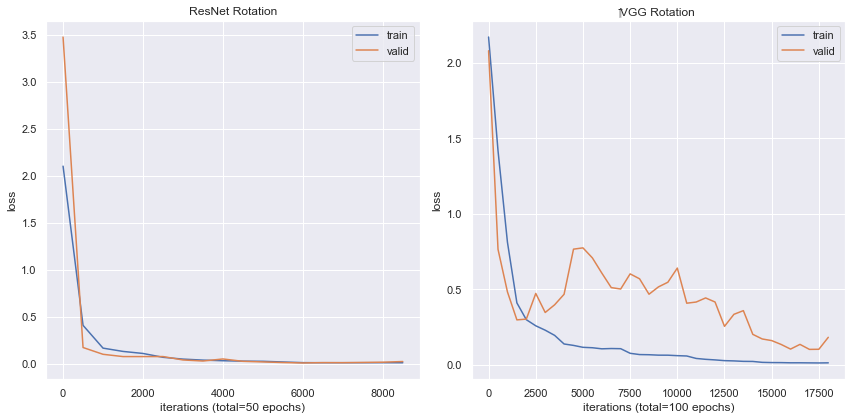

In [69]:
axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, len(train_results))
for i, (ax, train_file) in enumerate(zip(axs, train_results)):
    if names[i] == '‫‪VGG Rotation':
        ax.plot(iterations, train_file['train_loss'], label='train')
        ax.plot(iterations, train_file['valid_loss'], label='valid')
        ax.set_xlabel('iterations (total=100 epochs)')
    else:
        ax.plot(iterations[:total_records//2], train_file['train_loss'][:total_records//2], label='train')
        ax.plot(iterations[:total_records//2], train_file['valid_loss'][:total_records//2], label='valid')
        ax.set_xlabel('iterations (total=50 epochs)')
    ax.set_ylabel('loss')
    ax.legend(fancybox=True)
    ax.set_title(names[i])

fig = plt.gcf()
fig.tight_layout()
fig.savefig('./results/q3/loss_metrics.png', dpi=150)

# Test Results on CIFAR10

In [51]:
print_test_result(
    [get_results(f'./results/q3/results_adl_pj3_q3.{i}_last_layer_ts.pkl') for i in [1, 2]]
)

******************** cifar10 test results of part 1 (ResNet Rotation) ********************
loss (last stage): 1.3131002964117588
accuracy (last stage) : 0.5213741987179488
******************** cifar10 test results of part 2 (‫‪VGG Rotation) ********************
loss (last stage): 1.6562535290840343
accuracy (last stage) : 0.41170272435897437
